In [1]:
import brian2
import pickle
import scipy.io as sio
from pathlib import Path
import numpy as np



#brian2.test()

INFO       Cache size for target 'cython': 2252192766 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\bci-admin\.cython\brian_extensions' directory. [brian2]


In [2]:
from brian2 import *

### Preprocess and load data

In [3]:
import scipy.io as sio
from pathlib import Path
import numpy as np


mask = np.array([np.ones(32), np.ones(32), np.ones(32),np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3)))]).astype(np.bool)
mask = mask.reshape((1024,))

WARNING    C:\Users\bci-admin\AppData\Local\Temp\ipykernel_18932\3725482898.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.concatenate((np.zeros(25), np.ones(4), np.zeros(3)))]).astype(np.bool)
 [py.warnings]


In [4]:
numpy.count_nonzero(mask)

548

In [5]:
def normalize(pressure):
    """
    Scales each array of the given array of arrays to the range [0, 1]
    Only considers values in the same tactile frame
    """
    normalized_p = np.copy(pressure)
    for i, press in enumerate(pressure):
        min_p = np.min(press)
        normalized_p[i] = (press - min_p) / np.max(press - min_p)
    
    return normalized_p
 

def boost(pressure): 
    """
    The higher a value is from the mean of the frame, the more it gets boosted.
    The idea is that tactile features are robuster
    """
    for press in pressure:
        mean_p = np.mean(press[mask])
        boost_mask = press > mean_p
        press[boost_mask] = list(map(lambda x: 4*(x-mean_p), press[boost_mask]))
        
    return pressure

In [6]:
# Consider valid frames
# palm only or not?
filename = Path('C:/Users/bci-admin/Downloads/smarthand_dataset.mat')

data = sio.loadmat(filename, squeeze_me=True)

In [7]:
# Consider all frames
filename = Path('C:/Users/bci-admin/Downloads/smarthand_dataset.mat')

data = sio.loadmat(filename, squeeze_me=True)
# valid_mask = data['valid_flag'] == 1
pressure = data['tactile_data'] # [valid_mask]
# Scale data to the range [0, 1]
pressure = np.clip((pressure.astype(np.float32)-1500)/(2700-1500), 0.0, 1.0)
#pressure = normalize(pressure.astype(np.float32))
#pressure = np.exp2(pressure)
#pressure = np.clip((pressure-1), 0.0, 1.0)
#pressure = boost(pressure)
pressure = np.clip(pressure, 0.0, 1.0)

pressure[:, ~mask] = 0.0

object_id = data['object_id'] #[valid_mask]

In [8]:
pressure.shape

(339989, 1024)

In [9]:
pressure_nonzero = pressure[:, mask]

In [10]:
pressure_nonzero.shape

(339989, 548)

In [11]:
pressure.shape

(339989, 1024)

In [12]:
num_sessions = len(np.unique(data['session_id']))
num_objects = len(np.unique(data['object_id']))
x = []
y = []
z_session = []
sessions = data['session_id']
object_id = data['object_id']

for i in range(num_sessions):
    for j in range(num_objects):
        session_mask = sessions == i
        object_mask = object_id == j
        valid_mask = data['valid_flag'] == 1
        full_mask = session_mask & object_mask & valid_mask
        x.append(pressure_nonzero[full_mask])
        y.append(object_id[full_mask][0])
        z_session.append(i)
        
print(np.array(x).shape)
print(np.array(y).shape)

WARNING    C:\Users\bci-admin\AppData\Local\Temp\ipykernel_18932\2608531749.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(x).shape)
 [py.warnings]


(85,)
(85,)


In [13]:
min_len = 4000
for i in range(len(x)):
    print("id: {}, time steps: {}".format(i, x[i].shape[0]))
    if min_len > x[i].shape[0]:
        min_len = x[i].shape[0]
        
print("Min length: {}".format(min_len))

id: 0, time steps: 3113
id: 1, time steps: 3371
id: 2, time steps: 2863
id: 3, time steps: 3106
id: 4, time steps: 3226
id: 5, time steps: 4000
id: 6, time steps: 3352
id: 7, time steps: 2564
id: 8, time steps: 3028
id: 9, time steps: 2949
id: 10, time steps: 3062
id: 11, time steps: 3095
id: 12, time steps: 3267
id: 13, time steps: 3470
id: 14, time steps: 3364
id: 15, time steps: 3184
id: 16, time steps: 3125
id: 17, time steps: 1271
id: 18, time steps: 1867
id: 19, time steps: 1920
id: 20, time steps: 2320
id: 21, time steps: 1622
id: 22, time steps: 4000
id: 23, time steps: 2178
id: 24, time steps: 2128
id: 25, time steps: 2438
id: 26, time steps: 2483
id: 27, time steps: 2764
id: 28, time steps: 2734
id: 29, time steps: 3124
id: 30, time steps: 3095
id: 31, time steps: 2968
id: 32, time steps: 2698
id: 33, time steps: 1994
id: 34, time steps: 1418
id: 35, time steps: 1391
id: 36, time steps: 1626
id: 37, time steps: 1615
id: 38, time steps: 1588
id: 39, time steps: 4000
id: 40, ti

In [14]:
min_length = 1000

x_cut = np.zeros((len(x), min_length, x[0].shape[1]))
y_cut = np.zeros((len(x), min_length))

for i in range(len(x)):
    x_cut[i] = x[i][:min_length,:]
    y_cut[i] = np.array([y[i] for j in range(min_length)])

In [15]:
x_cut.shape

(85, 1000, 548)

In [16]:
y_cut.shape

(85, 1000)

In [17]:
x[0].shape

(3113, 548)

In [17]:
gains = [1/0.74, 1/0.69, 1/0.58, 1/0.45]

x_prev_full = x_cut[np.array(z_session) == 0]
y_prev_full = y_cut[np.array(z_session) == 0]

for i in range(len(gains)):
    x_cursess_cut = x_cut[np.array(z_session) == i + 1] * gains[i]
    y_cursess_cut = y_cut[np.array(z_session) == i + 1]
    x_fullsess_gained = np.concatenate([x_prev_full, x_cursess_cut])
    y_fullsess_gained = np.concatenate([y_prev_full, y_cursess_cut])
    x_prev_full = x_fullsess_gained
    y_prev_full = y_fullsess_gained

In [16]:
# 2 sessions gains
gains = [1/0.74]

x_prev_full = x_cut[np.array(z_session) == 0]
y_prev_full = y_cut[np.array(z_session) == 0]

for i in range(len(gains)):
    x_cursess_cut = x_cut[np.array(z_session) == i + 1] * gains[i]
    y_cursess_cut = y_cut[np.array(z_session) == i + 1]
    x_fullsess_gained = np.concatenate([x_prev_full, x_cursess_cut])
    y_fullsess_gained = np.concatenate([y_prev_full, y_cursess_cut])
    x_prev_full = x_fullsess_gained
    y_prev_full = y_fullsess_gained

In [17]:
# 3 sessions gains
gains = [1/0.74, 1/0.69]

x_prev_full = x_cut[np.array(z_session) == 0]
y_prev_full = y_cut[np.array(z_session) == 0]

for i in range(len(gains)):
    x_cursess_cut = x_cut[np.array(z_session) == i + 1] * gains[i]
    y_cursess_cut = y_cut[np.array(z_session) == i + 1]
    x_fullsess_gained = np.concatenate([x_prev_full, x_cursess_cut])
    y_fullsess_gained = np.concatenate([y_prev_full, y_cursess_cut])
    x_prev_full = x_fullsess_gained
    y_prev_full = y_fullsess_gained

In [18]:
x_sess1_cut = x_cut[np.array(z_session) == 0]
y_sess1_cut = y_cut[np.array(z_session) == 0]

In [19]:
x_sess2_cut = x_cut[np.array(z_session) == 1]
y_sess2_cut = y_cut[np.array(z_session) == 1]

In [17]:
x_sess1_cut = x_cut[np.array(z_session) == 0]
y_sess1_cut = y_cut[np.array(z_session) == 0]

x_sess2_cut = x_cut[np.array(z_session) == 1]
y_sess2_cut = y_cut[np.array(z_session) == 1]

x_sess3_cut = x_cut[np.array(z_session) == 2]
y_sess3_cut = y_cut[np.array(z_session) == 2]

x_sess123_cut = np.concatenate([x_sess1_cut, x_sess2_cut, x_sess3_cut])
y_sess123_cut = np.concatenate([y_sess1_cut, y_sess2_cut, y_sess3_cut])

In [18]:
x_sess123_cut.shape

(51, 1000, 548)

In [21]:
x_fullsess_gained[17]

array([[0.01689189, 0.03716216, 0.03265766, ..., 0.0213964 , 0.01689189,
        0.0045045 ],
       [0.01126126, 0.03378378, 0.02027027, ..., 0.01576577, 0.01576577,
        0.00112613],
       [0.0213964 , 0.0259009 , 0.02364865, ..., 0.01238739, 0.0213964 ,
        0.00112613],
       ...,
       [0.06756757, 0.10247748, 0.06756757, ..., 0.00788288, 0.0045045 ,
        0.00563063],
       [0.04954955, 0.10360361, 0.05855856, ..., 0.0045045 , 0.0045045 ,
        0.00225225],
       [0.07094594, 0.09121622, 0.06981982, ..., 0.0045045 , 0.00337838,
        0.00337838]])

In [22]:
1/0.74*x_sess2_cut[0]

array([[0.01689189, 0.03716216, 0.03265766, ..., 0.0213964 , 0.01689189,
        0.0045045 ],
       [0.01126126, 0.03378378, 0.02027027, ..., 0.01576577, 0.01576577,
        0.00112613],
       [0.0213964 , 0.0259009 , 0.02364865, ..., 0.01238739, 0.0213964 ,
        0.00112613],
       ...,
       [0.06756757, 0.10247748, 0.06756757, ..., 0.00788288, 0.0045045 ,
        0.00563063],
       [0.04954955, 0.10360361, 0.05855856, ..., 0.0045045 , 0.0045045 ,
        0.00225225],
       [0.07094594, 0.09121622, 0.06981982, ..., 0.0045045 , 0.00337838,
        0.00337838]])

In [24]:
x_fullsess_gained[34]

array([[0.02173913, 0.02657005, 0.03864734, ..., 0.00362319, 0.00362319,
        0.        ],
       [0.01328502, 0.0205314 , 0.03985507, ..., 0.00362319, 0.00724638,
        0.        ],
       [0.01570048, 0.01811594, 0.04951691, ..., 0.00483092, 0.00724638,
        0.        ],
       ...,
       [0.02777778, 0.03864734, 0.07608695, ..., 0.00120773, 0.00603865,
        0.        ],
       [0.01570048, 0.03140097, 0.102657  , ..., 0.00483092, 0.00845411,
        0.        ],
       [0.01328502, 0.02657005, 0.05434783, ..., 0.00362319, 0.        ,
        0.        ]])

In [25]:
1/0.69*x_cut[np.array(z_session) == 2][0]

array([[0.02173913, 0.02657005, 0.03864734, ..., 0.00362319, 0.00362319,
        0.        ],
       [0.01328502, 0.0205314 , 0.03985507, ..., 0.00362319, 0.00724638,
        0.        ],
       [0.01570048, 0.01811594, 0.04951691, ..., 0.00483092, 0.00724638,
        0.        ],
       ...,
       [0.02777778, 0.03864734, 0.07608695, ..., 0.00120773, 0.00603865,
        0.        ],
       [0.01570048, 0.03140097, 0.102657  , ..., 0.00483092, 0.00845411,
        0.        ],
       [0.01328502, 0.02657005, 0.05434783, ..., 0.00362319, 0.        ,
        0.        ]])

In [40]:
x_sess1_and_2_cut = np.concatenate([x_sess1_cut, x_sess2_cut])
y_sess1_and_2_cut = np.concatenate([y_sess1_cut, y_sess2_cut])

In [41]:
x_sess1_and_2_cut.shape

(34, 1000, 548)

In [43]:
y_sess1_and_2_cut.shape

(34, 1000)

In [20]:
x_sess1_cut.shape

(17, 1000, 548)

In [21]:
y_sess1_cut.shape

(17, 1000)

In [13]:
x_sess2_cut.shape

(17, 1000, 548)

In [14]:
y_sess2_cut.shape

(17, 1000)

### Spike conversion

In [22]:
# note that here, the unit of dt is s, so dt=0.01s

def bADM(input_signal,threshold_UP,threshold_DOWN,sampling_frequency,refractory_period_duration,return_signal = True):
    dt = 1/sampling_frequency
    end_time = len(input_signal)*dt
    times = np.linspace(0,end_time,len(input_signal)).astype(np.float64)
    DC_Voltage = input_signal[0]
    remainder_of_refractory = 0
    spike_t_up =  times[0:2]
    spike_t_dn = times[0:2]
    interpolate_from = 0.0
    interpolation_activation = 0
    intercept_point=0
    
    for i in range(len(times)):
        t = i * dt
        if i == 0:
            continue
        
        slope = ((input_signal[i]-input_signal[i-1])/dt)
        if remainder_of_refractory >= 2*dt:
            remainder_of_refractory = remainder_of_refractory-dt
            interpolation_activation = 1

        else:
            
            if interpolation_activation == 1:
                interpolate_from = (interpolate_from+remainder_of_refractory)
                remainder_of_refractory = 0
                if interpolate_from >= 2*dt:
                    interpolate_from = interpolate_from-dt
                    continue
                interpolate_from = (interpolate_from+remainder_of_refractory)%dt
                Vbelow = (input_signal[i-1] + interpolate_from*slope)
                DC_Voltage = Vbelow
            
                
            else:
                Vbelow = input_signal[i-1]
                interpolate_from = 0

            if DC_Voltage + threshold_UP <= input_signal[i]:
                intercept_point = t - dt + interpolate_from+((threshold_UP+DC_Voltage-Vbelow)/slope)
                spike_t_up = np.append(spike_t_up,intercept_point)
                interpolate_from = dt+intercept_point-t
                remainder_of_refractory = refractory_period_duration 
                interpolation_activation = 1
                continue

            elif DC_Voltage - threshold_DOWN >= input_signal[i]:
                intercept_point = t - dt + interpolate_from+((-threshold_DOWN+DC_Voltage-Vbelow)/slope)
                spike_t_dn = np.append(spike_t_dn,intercept_point)
                interpolate_from = dt+intercept_point-t
                remainder_of_refractory = refractory_period_duration 
                interpolation_activation = 1
                continue

            interpolation_activation = 0
                        
    index =[0,1]
    spike_t_up = np.delete(spike_t_up, index)
    spike_t_dn = np.delete(spike_t_dn, index)


#    if return_signal:
#        sup = np.zeros_like(times);sdw = np.zeros_like(times)
#        sup[np.searchsorted(times,spike_t_up,side='left')] = 1
#        sdw[np.searchsorted(times,spike_t_dn,side='left')] = 1
#        rsig=(threshold_UP * np.cumsum(sup)) + ((-threshold_DOWN) * np.cumsum(sdw)) + input_signal[0]

    return spike_t_up,spike_t_dn #,rsig

#### Session 1&2 spikes

In [52]:
# 2 sessions
delta = 0.03
ref = 0
sampling_freq = 100
N = 548

num_sessions = 2
num_objects = 17

full_list_up = []
full_list_dw = []

obj_range = range(num_objects*num_sessions)

for sample_index in obj_range:
    
    tuples_list_up = []
    tuples_list_dw = []
    
    for i in range(len(x_sess1_and_2_cut[sample_index].T)):
        sig = x_sess1_and_2_cut[sample_index].T[i]
        tup,tdw = bADM(sig,delta,delta,sampling_freq,ref)
        for item in tup:
            tuples_list_up.append((i, item + 10 * sample_index))
        for item in tdw:
            tuples_list_dw.append((i, item + 10 * sample_index))
    
    sorted_list_up = sorted(tuples_list_up, key=lambda x: (x[1], x[0]))
    full_list_up.extend(sorted_list_up)
    
    sorted_list_dw = sorted(tuples_list_dw, key=lambda x: (x[1], x[0]))
    full_list_dw.extend(sorted_list_dw)
    
    print("No. {} train sample processed".format(sample_index))

indices_list_up = [x[0] for x in full_list_up]
times_list_up = [x[1] for x in full_list_up]  # *1000

indices_list_dw = [x[0] for x in full_list_dw]
times_list_dw = [x[1] for x in full_list_dw]  # *1000

No. 0 train sample processed
No. 1 train sample processed
No. 2 train sample processed
No. 3 train sample processed
No. 4 train sample processed
No. 5 train sample processed
No. 6 train sample processed
No. 7 train sample processed
No. 8 train sample processed
No. 9 train sample processed
No. 10 train sample processed
No. 11 train sample processed
No. 12 train sample processed
No. 13 train sample processed
No. 14 train sample processed
No. 15 train sample processed
No. 16 train sample processed
No. 17 train sample processed
No. 18 train sample processed
No. 19 train sample processed
No. 20 train sample processed
No. 21 train sample processed
No. 22 train sample processed
No. 23 train sample processed
No. 24 train sample processed
No. 25 train sample processed
No. 26 train sample processed
No. 27 train sample processed
No. 28 train sample processed
No. 29 train sample processed
No. 30 train sample processed
No. 31 train sample processed
No. 32 train sample processed
No. 33 train sample 

In [53]:
print(times_list_dw[-1])

339.9889488608019


In [54]:
len(indices_list_up)

115740

In [55]:
len(indices_list_dw)

95589

#### Session 1&2&3 spikes

In [ ]:
# 3 sessions
delta = 0.03
ref = 0
sampling_freq = 100
N = 548

num_sessions = 3
num_objects = 17

full_list_up = []
full_list_dw = []

obj_range = range(num_objects*num_sessions)

for sample_index in obj_range:
    
    tuples_list_up = []
    tuples_list_dw = []
    
    for i in range(len(x_sess123_cut[sample_index].T)):
        sig = x_sess123_cut[sample_index].T[i]
        tup,tdw = bADM(sig,delta,delta,sampling_freq,ref)
        for item in tup:
            tuples_list_up.append((i, item + 10 * sample_index))
        for item in tdw:
            tuples_list_dw.append((i, item + 10 * sample_index))
    
    sorted_list_up = sorted(tuples_list_up, key=lambda x: (x[1], x[0]))
    full_list_up.extend(sorted_list_up)
    
    sorted_list_dw = sorted(tuples_list_dw, key=lambda x: (x[1], x[0]))
    full_list_dw.extend(sorted_list_dw)
    
    print("No. {} train sample processed".format(sample_index))

indices_list_up = [x[0] for x in full_list_up]
times_list_up = [x[1] for x in full_list_up]  # *1000

indices_list_dw = [x[0] for x in full_list_dw]
times_list_dw = [x[1] for x in full_list_dw]  # *1000

In [22]:
print(times_list_dw[-1])

509.9889198857247


In [23]:
len(indices_list_up)

160283

In [24]:
len(indices_list_dw)

130780

In [25]:
print(times_list_dw[-1])

509.98904797866044


In [26]:
len(indices_list_up)

260242

In [27]:
len(indices_list_dw)

217743

#### Full 5 sessions, gained

In [33]:
# 5 sessions, x_fullsess_gained 0.03
delta = 0.03
ref = 0
sampling_freq = 100
N = 548

num_sessions = 5
num_objects = 17

full_list_up = []
full_list_dw = []

obj_range = range(num_objects*num_sessions)

for sample_index in obj_range:
    
    tuples_list_up = []
    tuples_list_dw = []
    
    for i in range(len(x_fullsess_gained[sample_index].T)):
        sig = x_fullsess_gained[sample_index].T[i]
        tup,tdw = bADM(sig,delta,delta,sampling_freq,ref)
        for item in tup:
            tuples_list_up.append((i, item + 10 * sample_index))
        for item in tdw:
            tuples_list_dw.append((i, item + 10 * sample_index))
    
    sorted_list_up = sorted(tuples_list_up, key=lambda x: (x[1], x[0]))
    full_list_up.extend(sorted_list_up)
    
    sorted_list_dw = sorted(tuples_list_dw, key=lambda x: (x[1], x[0]))
    full_list_dw.extend(sorted_list_dw)
    
    print("No. {} train sample processed".format(sample_index))

indices_list_up = [x[0] for x in full_list_up]
times_list_up = [x[1] for x in full_list_up]  # *1000

indices_list_dw = [x[0] for x in full_list_dw]
times_list_dw = [x[1] for x in full_list_dw]  # *1000

No. 0 train sample processed
No. 1 train sample processed
No. 2 train sample processed
No. 3 train sample processed
No. 4 train sample processed
No. 5 train sample processed
No. 6 train sample processed
No. 7 train sample processed
No. 8 train sample processed
No. 9 train sample processed
No. 10 train sample processed
No. 11 train sample processed
No. 12 train sample processed
No. 13 train sample processed
No. 14 train sample processed
No. 15 train sample processed
No. 16 train sample processed
No. 17 train sample processed
No. 18 train sample processed
No. 19 train sample processed
No. 20 train sample processed
No. 21 train sample processed
No. 22 train sample processed
No. 23 train sample processed
No. 24 train sample processed
No. 25 train sample processed
No. 26 train sample processed
No. 27 train sample processed
No. 28 train sample processed
No. 29 train sample processed
No. 30 train sample processed
No. 31 train sample processed
No. 32 train sample processed
No. 33 train sample 

In [34]:
print(times_list_dw[-1])

849.9899191094643


In [35]:
len(indices_list_up)

593324

In [36]:
len(indices_list_dw)

502275

In [40]:
with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/spikes_N_4000/full_list_up_0.01_cut1000_reducedInputs_5Sess_gained", "wb") as fp: 
    pickle.dump(full_list_up, fp)
    
with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/spikes_N_4000/full_list_dw_0.01_cut1000_reducedInputs_5Sess_gained", "wb") as fp: 
    pickle.dump(full_list_dw, fp)

#### Full 5 sessions, gained, thres=0.05

In [31]:
# 5 sessions, x_fullsess_gained, 0.05
delta = 0.05
ref = 0
sampling_freq = 100
N = 548

num_sessions = 5
num_objects = 17

full_list_up = []
full_list_dw = []

obj_range = range(num_objects*num_sessions)

for sample_index in obj_range:
    
    tuples_list_up = []
    tuples_list_dw = []
    
    for i in range(len(x_fullsess_gained[sample_index].T)):
        sig = x_fullsess_gained[sample_index].T[i]
        tup,tdw = bADM(sig,delta,delta,sampling_freq,ref)
        for item in tup:
            tuples_list_up.append((i, item + 10 * sample_index))
        for item in tdw:
            tuples_list_dw.append((i, item + 10 * sample_index))
    
    sorted_list_up = sorted(tuples_list_up, key=lambda x: (x[1], x[0]))
    full_list_up.extend(sorted_list_up)
    
    sorted_list_dw = sorted(tuples_list_dw, key=lambda x: (x[1], x[0]))
    full_list_dw.extend(sorted_list_dw)
    
    print("No. {} train sample processed".format(sample_index))

indices_list_up = [x[0] for x in full_list_up]
times_list_up = [x[1] for x in full_list_up]  # *1000

indices_list_dw = [x[0] for x in full_list_dw]
times_list_dw = [x[1] for x in full_list_dw]  # *1000

No. 0 train sample processed
No. 1 train sample processed
No. 2 train sample processed
No. 3 train sample processed
No. 4 train sample processed
No. 5 train sample processed
No. 6 train sample processed
No. 7 train sample processed
No. 8 train sample processed
No. 9 train sample processed
No. 10 train sample processed
No. 11 train sample processed
No. 12 train sample processed
No. 13 train sample processed
No. 14 train sample processed
No. 15 train sample processed
No. 16 train sample processed
No. 17 train sample processed
No. 18 train sample processed
No. 19 train sample processed
No. 20 train sample processed
No. 21 train sample processed
No. 22 train sample processed
No. 23 train sample processed
No. 24 train sample processed
No. 25 train sample processed
No. 26 train sample processed
No. 27 train sample processed
No. 28 train sample processed
No. 29 train sample processed
No. 30 train sample processed
No. 31 train sample processed
No. 32 train sample processed
No. 33 train sample 

In [32]:
print(times_list_dw[-1])

849.9883751251787


In [33]:
len(indices_list_up)

214643

In [34]:
len(indices_list_dw)

171570

#### Full 5 sessions, no gain, 0.05

In [17]:
# 5 sessions, no gain
delta = 0.05 # 0.03
ref = 0
sampling_freq = 100
N = 548

num_sessions = 5
num_objects = 17

full_list_up = []
full_list_dw = []

obj_range = range(num_objects*num_sessions)

for sample_index in obj_range:
    
    tuples_list_up = []
    tuples_list_dw = []
    
    for i in range(len(x_cut[sample_index].T)):
        sig = x_cut[sample_index].T[i]
        tup,tdw = bADM(sig,delta,delta,sampling_freq,ref)
        for item in tup:
            tuples_list_up.append((i, item + 10 * sample_index))
        for item in tdw:
            tuples_list_dw.append((i, item + 10 * sample_index))
    
    sorted_list_up = sorted(tuples_list_up, key=lambda x: (x[1], x[0]))
    full_list_up.extend(sorted_list_up)
    
    sorted_list_dw = sorted(tuples_list_dw, key=lambda x: (x[1], x[0]))
    full_list_dw.extend(sorted_list_dw)
    
    print("No. {} train sample processed".format(sample_index))

indices_list_up = [x[0] for x in full_list_up]
times_list_up = [x[1] for x in full_list_up]  # *1000

indices_list_dw = [x[0] for x in full_list_dw]
times_list_dw = [x[1] for x in full_list_dw]  # *1000

No. 0 train sample processed
No. 1 train sample processed
No. 2 train sample processed
No. 3 train sample processed
No. 4 train sample processed
No. 5 train sample processed
No. 6 train sample processed
No. 7 train sample processed
No. 8 train sample processed
No. 9 train sample processed
No. 10 train sample processed
No. 11 train sample processed
No. 12 train sample processed
No. 13 train sample processed
No. 14 train sample processed
No. 15 train sample processed
No. 16 train sample processed
No. 17 train sample processed
No. 18 train sample processed
No. 19 train sample processed
No. 20 train sample processed
No. 21 train sample processed
No. 22 train sample processed
No. 23 train sample processed
No. 24 train sample processed
No. 25 train sample processed
No. 26 train sample processed
No. 27 train sample processed
No. 28 train sample processed
No. 29 train sample processed
No. 30 train sample processed
No. 31 train sample processed
No. 32 train sample processed
No. 33 train sample 

In [18]:
print(times_list_dw[-1])

849.9882389895655


In [19]:
len(indices_list_up)

81347

In [20]:
len(indices_list_dw)

61599

### Randomized connections between input and hidden layer

In [58]:
N = 548

i_list = []
j_list = []

for i in range(N):
    for j in range(3*N):
        if rand(1)[0] < 0.4:
            i_list.append(i)
            j_list.append(j)

In [59]:
# with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/spikes_N_4000/i_list_N548_0.4", "wb") as fp: 
#     pickle.dump(i_list, fp)
    
# with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/spikes_N_4000/j_list_N548_0.4", "wb") as fp: 
#     pickle.dump(j_list, fp)

In [15]:
# with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/spikes_N_4000/i_list_0.4", "wb") as fp: 
#     pickle.dump(i_list, fp)
    
# with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/spikes_N_4000/j_list_0.4", "wb") as fp: 
#     pickle.dump(j_list, fp)

In [27]:
with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/spikes_N_4000/i_list_N548_0.4", "rb") as fp:   # Unpickling
    i_list = pickle.load(fp)
    
with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/spikes_N_4000/j_list_N548_0.4", "rb") as fp: 
    j_list = pickle.load(fp)

In [28]:
len(i_list)

360313

In [29]:
len(j_list)

360313

### SNN

In [13]:
# 1 session

start_scope()

y = np.array([i for i in range(17)])

defaultclock.dt = 1*ms

num_sessions = 1
num_objects = 17

N = 548 # 1024

# alpha = 0.001
# time_const_tau = 100 # Also needs adjusting later!

sample_index = 0
cnt = 0

cur_class = int(y[0])

Neuron_group = {}
Synapse = {}
Spike_monitor = {} 
State_monitor = {} 

Neuron_group['IN_exc'] = SpikeGeneratorGroup(N, np.array(indices_list_up), np.array(times_list_up)*second, sorted=True)
Neuron_group['IN_inh'] = SpikeGeneratorGroup(N, np.array(indices_list_dw), np.array(times_list_dw)*second, sorted=True)

# eqs = '''
# dv/dt = (I-v)/tau : 1
# I : 1
# tau : second
# '''

# Neuronal Parameters
c = 100*pF
vl = -70*mV
gl = 5*nS
 
# Synaptic Parameters
ge_tau_def = 20*ms # Also needs adjusting later!  ori: 20
ve = 0*mV
gi_tau_def = 180*ms # Also needs adjusting later!  ori: 100
vi = -80*mV
w_ge_def = 1.0*nS # ori: 1.0*nS 
w_gi_def = 0.2*nS # 0.05, tune params, optimize
 
lif = '''
dv/dt = -(gl * (v - vl) + ge * (v - ve) + gi *(ve - vi) - I)/c : volt
dge/dt = -ge / ge_tau : siemens
dgi/dt = -gi / gi_tau : siemens
I : amp
ge_tau: second
gi_tau: second
'''

Neuron_group['HID'] = NeuronGroup(3*N, lif, threshold='v>-40*mV', reset='v = vl', method='euler')
Neuron_group['HID'].I = [0 for i in range(3*N)]*nA
Neuron_group['HID'].v = [-70 for i in range(3*N)]*mV
Neuron_group['HID'].ge_tau = [ge_tau_def + 0.2*ge_tau_def*np.random.randn() for i in range(3*N)]
Neuron_group['HID'].gi_tau = [gi_tau_def + 0.2*gi_tau_def*np.random.randn() for i in range(3*N)]

Synapse['S1_exc'] = Synapses(Neuron_group['IN_exc'], Neuron_group['HID'], 'w_ge : siemens', on_pre='ge_post += w_ge', name='S1_exc')
Synapse['S1_exc'].connect(i=i_list, j=j_list)
Synapse['S1_exc'].w_ge = 'w_ge_def + randn()*w_ge_def*0.2'  # Gaussian of mean and std  # Stronger than inhibitory

Synapse['S1_inh'] = Synapses(Neuron_group['IN_inh'], Neuron_group['HID'], 'w_gi : siemens', on_pre='gi_post -= w_gi', name='S1_inh')
Synapse['S1_inh'].connect(i=i_list, j=j_list) # Connect to the same neuron!
Synapse['S1_inh'].w_gi = 'w_gi_def + randn()*w_gi_def*0.2'  # Gaussian of mean and std

# for cycle   New neuron add to synapse, +-20%    every time a new value
 
State_monitor['HID'] = StateMonitor(Neuron_group['HID'], 'v', record=0)

Spike_monitor['HID'] = SpikeMonitor(Neuron_group['HID'])

net = Network()
for obj_sim in [Neuron_group, Spike_monitor, Synapse, State_monitor]:
    for key in obj_sim:
        net.add(obj_sim[key])
    
    
    # Synapse['S2'].difw[:, :cur_class] = 'alpha*(0-v_post)*v_pre'
    # Synapse['S2'].difw[:, cur_class+1:] = 'alpha*(0-v_post)*v_pre'
    # Synapse['S2'].difw[:, cur_class] = 'alpha*(1-v_post)*v_pre'
    
for sample_index in range(num_sessions * num_objects):
    cur_class = int(y[sample_index])

    net.run(10000*ms) # 40s per sample, 0.04ks
    print("Train sample No. {} processed, current class: {}".format(sample_index, cur_class))
    
# 1-> timedarray more proper?

Train sample No. 0 processed, current class: 0
Train sample No. 1 processed, current class: 1
Train sample No. 2 processed, current class: 2
Train sample No. 3 processed, current class: 3
Train sample No. 4 processed, current class: 4
Train sample No. 5 processed, current class: 5
Train sample No. 6 processed, current class: 6
Train sample No. 7 processed, current class: 7
Train sample No. 8 processed, current class: 8
Train sample No. 9 processed, current class: 9
Train sample No. 10 processed, current class: 10
Train sample No. 11 processed, current class: 11
Train sample No. 12 processed, current class: 12
Train sample No. 13 processed, current class: 13
Train sample No. 14 processed, current class: 14
Train sample No. 15 processed, current class: 15
Train sample No. 16 processed, current class: 16


Text(0, 0.5, 'v')

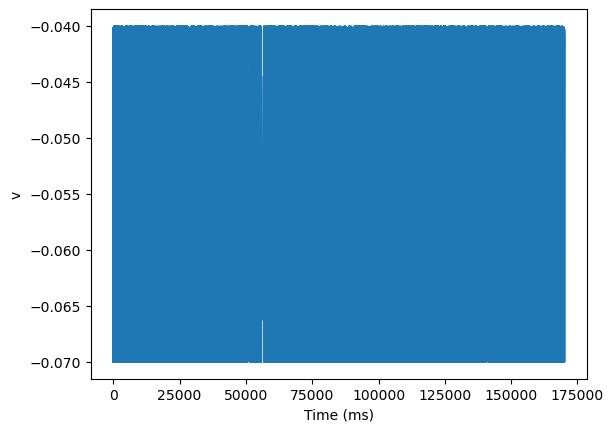

In [14]:
plot(State_monitor['HID'].t/ms, State_monitor['HID'].v[0])
xlabel('Time (ms)')
ylabel('v')

### Voltage Clamp Version of SNN

In [30]:
# Clamping
# 1 session

start_scope()

y = np.array([i for i in range(17)])

defaultclock.dt = 1*ms

num_sessions = 1
num_objects = 17

N = 548 # 1024

# alpha = 0.001
# time_const_tau = 100 # Also needs adjusting later!

sample_index = 0
cnt = 0

cur_class = int(y[0])

Neuron_group = {}
Synapse = {}
Spike_monitor = {} 
State_monitor = {} 

Neuron_group['IN_exc'] = SpikeGeneratorGroup(N, np.array(indices_list_up), np.array(times_list_up)*second, sorted=True)
Neuron_group['IN_inh'] = SpikeGeneratorGroup(N, np.array(indices_list_dw), np.array(times_list_dw)*second, sorted=True)

# eqs = '''
# dv/dt = (I-v)/tau : 1
# I : 1
# tau : second
# '''

# Neuronal Parameters
c = 100*pF
vl = 10*mV
gl = 5*nS
 
# Synaptic Parameters
ge_tau_def = 20*ms # Also needs adjusting later!  ori: 20
ve = 80*mV
gi_tau_def = 180*ms # Also needs adjusting later!  ori: 100
vi = 0*mV
w_ge_def = 1.0*nS # ori: 1.0*nS 
w_gi_def = 0.2*nS # 0.05, tune params, optimize
thres = 40*mV
 
# lif = '''
# dv/dt = -(gl * (v - vl) + ge * (v - ve) + gi *(ve - vi) - I)/c : volt
# dge/dt = -ge / ge_tau : siemens
# dgi/dt = -gi / gi_tau : siemens
# I : amp
# ge_tau: second
# gi_tau: second
# '''
    
lif = '''
dv/dt = -(gl * (v_clip - vl) + ge * (v_clip - ve) + gi *(ve - vi) - I)/c : volt
dge/dt = -ge / ge_tau : siemens
dgi/dt = -gi / gi_tau : siemens
v_clip = clip(v, 0*mV, thres) : volt
I : amp
ge_tau: second
gi_tau: second
'''

Neuron_group['HID'] = NeuronGroup(3*N, lif, threshold='v>thres', reset='v = vl', method='euler')
Neuron_group['HID'].I = [0 for i in range(3*N)]*nA
Neuron_group['HID'].v = [10 for i in range(3*N)]*mV
Neuron_group['HID'].ge_tau = [ge_tau_def + 0.2*ge_tau_def*np.random.randn() for i in range(3*N)]
Neuron_group['HID'].gi_tau = [gi_tau_def + 0.2*gi_tau_def*np.random.randn() for i in range(3*N)]

Synapse['S1_exc'] = Synapses(Neuron_group['IN_exc'], Neuron_group['HID'], 'w_ge : siemens', on_pre='ge_post += w_ge', name='S1_exc')
Synapse['S1_exc'].connect(i=i_list, j=j_list)
Synapse['S1_exc'].w_ge = 'w_ge_def + randn()*w_ge_def*0.2'  # Gaussian of mean and std  # Stronger than inhibitory

Synapse['S1_inh'] = Synapses(Neuron_group['IN_inh'], Neuron_group['HID'], 'w_gi : siemens', on_pre='gi_post -= w_gi', name='S1_inh')
Synapse['S1_inh'].connect(i=i_list, j=j_list) # Connect to the same neuron!
Synapse['S1_inh'].w_gi = 'w_gi_def + randn()*w_gi_def*0.2'  # Gaussian of mean and std

# for cycle   New neuron add to synapse, +-20%    every time a new value
 
State_monitor['HID'] = StateMonitor(Neuron_group['HID'], 'v', record=0)

Spike_monitor['HID'] = SpikeMonitor(Neuron_group['HID'])

net = Network()
for obj_sim in [Neuron_group, Spike_monitor, Synapse, State_monitor]:
    for key in obj_sim:
        net.add(obj_sim[key])
    
    
    # Synapse['S2'].difw[:, :cur_class] = 'alpha*(0-v_post)*v_pre'
    # Synapse['S2'].difw[:, cur_class+1:] = 'alpha*(0-v_post)*v_pre'
    # Synapse['S2'].difw[:, cur_class] = 'alpha*(1-v_post)*v_pre'
    
for sample_index in range(num_sessions * num_objects):
    cur_class = int(y[sample_index])

    net.run(10000*ms) # 40s per sample, 0.04ks
    print("Train sample No. {} processed, current class: {}".format(sample_index, cur_class))
    
# 1-> timedarray more proper?

Train sample No. 0 processed, current class: 0
Train sample No. 1 processed, current class: 1
Train sample No. 2 processed, current class: 2
Train sample No. 3 processed, current class: 3
Train sample No. 4 processed, current class: 4
Train sample No. 5 processed, current class: 5
Train sample No. 6 processed, current class: 6
Train sample No. 7 processed, current class: 7
Train sample No. 8 processed, current class: 8
Train sample No. 9 processed, current class: 9
Train sample No. 10 processed, current class: 10
Train sample No. 11 processed, current class: 11
Train sample No. 12 processed, current class: 12
Train sample No. 13 processed, current class: 13
Train sample No. 14 processed, current class: 14
Train sample No. 15 processed, current class: 15
Train sample No. 16 processed, current class: 16


In [33]:
spike_trains = Spike_monitor['HID'].spike_trains()

In [34]:
len(spike_trains)

1644

In [35]:
spike_trains

{0: array([7.90000e-02, 9.10000e-02, 1.03000e-01, ..., 1.69990e+02,
        1.69994e+02, 1.69998e+02]) * second,
 1: array([8.80000e-02, 1.00000e-01, 1.55000e-01, ..., 1.69985e+02,
        1.69990e+02, 1.69995e+02]) * second,
 2: array([8.60000e-02, 9.50000e-02, 1.13000e-01, ..., 1.69986e+02,
        1.69991e+02, 1.69996e+02]) * second,
 3: array([9.80000e-02, 1.53000e-01, 1.73000e-01, ..., 1.69985e+02,
        1.69991e+02, 1.69998e+02]) * second,
 4: array([8.60000e-02, 1.72000e-01, 1.90000e-01, ..., 1.69986e+02,
        1.69991e+02, 1.69996e+02]) * second,
 5: array([7.80000e-02, 8.80000e-02, 9.70000e-02, ..., 1.69988e+02,
        1.69993e+02, 1.69999e+02]) * second,
 6: array([  0.172,   0.252,   0.312, ..., 169.982, 169.99 , 169.998]) * second,
 7: array([8.70000e-02, 9.70000e-02, 1.11000e-01, ..., 1.69987e+02,
        1.69992e+02, 1.69997e+02]) * second,
 8: array([9.30000e-02, 1.10000e-01, 1.51000e-01, ..., 1.69986e+02,
        1.69990e+02, 1.69995e+02]) * second,
 9: array([8.90

Text(0, 0.5, 'v')

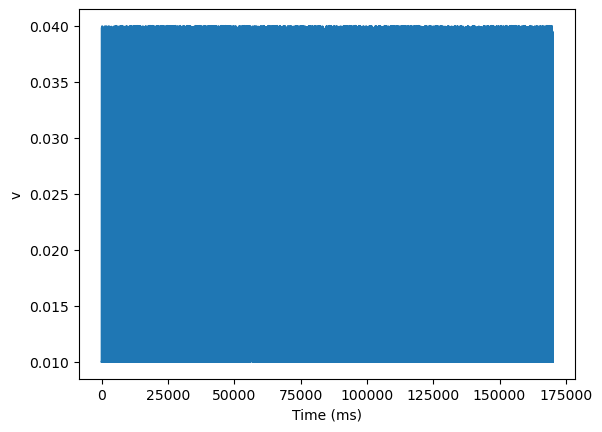

In [36]:
plot(State_monitor['HID'].t/ms, State_monitor['HID'].v[0])
xlabel('Time (ms)')
ylabel('v')

### Classification on Session 1 data, 17 classes

#### N_frames = 10, no voltage clamp, session 1

In [ ]:
# Session 1
# Full 17 classes
# With Gaussian
# p = 0.4, tau = 20, 100
gaussian_length = 8
radius = int(gaussian_length / 2)

def gaussian(x, s):
    return 1./np.sqrt(2. * np.pi * s**2) * np.exp(-x**2 / (2. * s**2))

myGaussian = np.fromiter((gaussian(x, 20) for x in range(-radius, radius+1, 1) ), np.float)

num_objects = 17
num_sessions = 1

sampling_freq = 100

N = 548

num_cnt = 25 # Maybe modify later? Not suitable for samp. freq.=100, too many values, unable to svm later!

labels = []  # shape: 85 * int(4000/N_frames)
binned_signals = [] # shape: 85 * int(4000/N_frames) * 3072 * len(sup)

y = np.array([i for i in range(17)])

N_frames = 10
time_gap = N_frames * 10 / 1000 # unit: second
full_time = 10 * num_objects * num_sessions # unit: second

for i in range(num_objects*num_sessions): # 85 subjects, 4000 frames per subject
    print("Recording No.: {}".format(i))
    for j in range(int(1000/N_frames)): # each subject has int(4000/N_frames) samples. Every sample consumes time_gap seconds.
        labels.append(y[i])
        sup_arr_for_one_sample = []
        
        for neuron_id in range(len(spike_trains)):
            num_slot = i * int(1000/N_frames) + j
            cur_arr = spike_trains[neuron_id] * 1000 /ksecond # unit: second
            selected_arr = cur_arr[(cur_arr >= time_gap * num_slot) & (cur_arr < time_gap * (num_slot+1))] - time_gap * num_slot
            
            # if selected_arr != np.array([]):
                # print(selected_arr)
            
            dt = 1/sampling_freq # unit: second
            times = np.linspace(0,time_gap,num_cnt).astype(np.float64)

            sup = np.zeros_like(times)
            sup[np.searchsorted(times,selected_arr,side='left')] = 1
            
            myFilteredData_Gaussian = np.convolve(sup, myGaussian, mode='same' )
            
            sup_arr_for_one_sample.append(myFilteredData_Gaussian)
        
        binned_signals.append(np.array(sup_arr_for_one_sample))

In [21]:
# Session 1
# -40mv Gaussian, theta = 0.03, w_ge_def = 1.0*nS, 10frames per sample
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(1360, 41100)
(1360,)
Accuracy: 0.8941176470588236


#### N_frames = 5, voltage clamp, session 1

In [ ]:
# Session 1, Voltage Clamp, 5 frames
# Full 17 classes
# With Gaussian
# p = 0.4, tau = 20, 100
gaussian_length = 5
radius = int(gaussian_length / 2)

def gaussian(x, s):
    return 1./np.sqrt(2. * np.pi * s**2) * np.exp(-x**2 / (2. * s**2))

myGaussian = np.fromiter((gaussian(x, 5) for x in range(-radius, radius+1, 1) ), np.float)

num_objects = 17
num_sessions = 1

sampling_freq = 100

N = 548

num_cnt = 25 # Maybe modify later? Not suitable for samp. freq.=100, too many values, unable to svm later!

labels = []  # shape: 85 * int(4000/N_frames)
binned_signals = [] # shape: 85 * int(4000/N_frames) * 3072 * len(sup)

y = np.array([i for i in range(17)])

N_frames = 5
time_gap = N_frames * 10 / 1000 # unit: second
full_time = 10 * num_objects * num_sessions # unit: second

for i in range(num_objects*num_sessions): # 85 subjects, 4000 frames per subject
    print(i)
    for j in range(int(1000/N_frames)): # each subject has int(4000/N_frames) samples. Every sample consumes time_gap seconds.
        labels.append(y[i])
        sup_arr_for_one_sample = []
        
        for neuron_id in range(len(spike_trains)):
            num_slot = i * int(1000/N_frames) + j
            cur_arr = spike_trains[neuron_id] * 1000 /ksecond # unit: second
            selected_arr = cur_arr[(cur_arr >= time_gap * num_slot) & (cur_arr < time_gap * (num_slot+1))] - time_gap * num_slot
            
            # if selected_arr != np.array([]):
                # print(selected_arr)
            
            dt = 1/sampling_freq # unit: second
            times = np.linspace(0,time_gap,num_cnt).astype(np.float64)

            sup = np.zeros_like(times)
            sup[np.searchsorted(times,selected_arr,side='left')] = 1
            
            myFilteredData_Gaussian = np.convolve(sup, myGaussian, mode='same' )
            
            sup_arr_for_one_sample.append(myFilteredData_Gaussian)
        
        binned_signals.append(np.array(sup_arr_for_one_sample))

In [ ]:
np.array(binned_signals).shape

In [33]:
# Session 1, clipped, 5 frames
# -40mv Gaussian, theta = 0.03, w_ge_def = 1.0*nS, 10frames per sample
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(2720, 41100)
(2720,)
Accuracy: 0.8970588235294118


#### N_frames = 5, voltage clamp, Laplacian kernel, session 1

In [38]:
# Session 1, clipped, 5 frames
# Full 17 classes
# With Gaussian
# p = 0.4, tau = 20, 100
gaussian_length = 5
radius = int(gaussian_length / 2)

def laplacian(x, s):
    return np.exp(-abs(x)/s)/(2.*s)

myLaplacian = np.fromiter((laplacian(x, 5) for x in range(-radius, radius+1, 1) ), np.float)

num_objects = 17
num_sessions = 1

sampling_freq = 100

N = 548

num_cnt = 25 # Maybe modify later? Not suitable for samp. freq.=100, too many values, unable to svm later!

labels = []  # shape: 85 * int(4000/N_frames)
binned_signals = [] # shape: 85 * int(4000/N_frames) * 3072 * len(sup)

y = np.array([i for i in range(17)])

N_frames = 5
time_gap = N_frames * 10 / 1000 # unit: second
full_time = 10 * num_objects * num_sessions # unit: second

for i in range(num_objects*num_sessions): # 85 subjects, 4000 frames per subject
    print(i)
    for j in range(int(1000/N_frames)): # each subject has int(4000/N_frames) samples. Every sample consumes time_gap seconds.
        labels.append(y[i])
        sup_arr_for_one_sample = []
        
        for neuron_id in range(len(spike_trains)):
            num_slot = i * int(1000/N_frames) + j
            cur_arr = spike_trains[neuron_id] * 1000 /ksecond # unit: second
            selected_arr = cur_arr[(cur_arr >= time_gap * num_slot) & (cur_arr < time_gap * (num_slot+1))] - time_gap * num_slot
            
            # if selected_arr != np.array([]):
                # print(selected_arr)
            
            dt = 1/sampling_freq # unit: second
            times = np.linspace(0,time_gap,num_cnt).astype(np.float64)

            sup = np.zeros_like(times)
            sup[np.searchsorted(times,selected_arr,side='left')] = 1
            
            myFilteredData_Laplacian = np.convolve(sup, myLaplacian, mode='same' )
            
            sup_arr_for_one_sample.append(myFilteredData_Laplacian)
        
        binned_signals.append(np.array(sup_arr_for_one_sample))

WARNING    C:\Users\bci-admin\AppData\Local\Temp\ipykernel_16532\1041421179.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  myLaplacian = np.fromiter((laplacian(x, 5) for x in range(-radius, radius+1, 1) ), np.float)
 [py.warnings]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [39]:
# Session 1, clipped, 5 frames
# -40mv Gaussian, theta = 0.03, w_ge_def = 1.0*nS, 10frames per sample
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(2720, 41100)
(2720,)
Accuracy: 0.9


#### N_frames = 5, voltage clamp, LPF, session 1

In [41]:
# Session 1, clipped, 5 frames
# Full 17 classes
# With Gaussian
# p = 0.4, tau = 20, 100

from scipy.signal import butter,filtfilt

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, padlen=len(data)-1)
    return y

# Filter requirements.
T = 1.0         # Sample Period
fs = 100       # sample rate, Hz
cutoff = 5      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 10       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples


num_objects = 17
num_sessions = 1

sampling_freq = 100

N = 548

num_cnt = 25 # Maybe modify later? Not suitable for samp. freq.=100, too many values, unable to svm later!

labels = []  # shape: 85 * int(4000/N_frames)
binned_signals = [] # shape: 85 * int(4000/N_frames) * 3072 * len(sup)

y = np.array([i for i in range(17)])

N_frames = 5
time_gap = N_frames * 10 / 1000 # unit: second
full_time = 10 * num_objects * num_sessions # unit: second

for i in range(num_objects*num_sessions): # 85 subjects, 4000 frames per subject
    print(i)
    for j in range(int(1000/N_frames)): # each subject has int(4000/N_frames) samples. Every sample consumes time_gap seconds.
        labels.append(y[i])
        sup_arr_for_one_sample = []
        
        for neuron_id in range(len(spike_trains)):
            num_slot = i * int(1000/N_frames) + j
            cur_arr = spike_trains[neuron_id] * 1000 /ksecond # unit: second
            selected_arr = cur_arr[(cur_arr >= time_gap * num_slot) & (cur_arr < time_gap * (num_slot+1))] - time_gap * num_slot
            
            # if selected_arr != np.array([]):
                # print(selected_arr)
            
            dt = 1/sampling_freq # unit: second
            times = np.linspace(0,time_gap,num_cnt).astype(np.float64)

            sup = np.zeros_like(times)
            sup[np.searchsorted(times,selected_arr,side='left')] = 1
            
            myLPF = butter_lowpass_filter(sup, cutoff, fs, order)
            
            sup_arr_for_one_sample.append(myLPF)
        
        binned_signals.append(np.array(sup_arr_for_one_sample))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [42]:
# Session 1, clipped, 5 frames
# -40mv Gaussian, theta = 0.03, w_ge_def = 1.0*nS, 10frames per sample
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(2720, 41100)
(2720,)
Accuracy: 0.513235294117647


#### N_frames = 5, voltage clamp, exponential kernel, session 1

In [43]:
# Session 1, clipped, 5 frames
# Full 17 classes
# With Gaussian
# p = 0.4, tau = 20, 100
exp_length = 10

def exponential(x, lam):
    return lam*exp(-lam*x)

myExponential = np.fromiter((exponential(x, 5) for x in range(0, exp_length+1) ), np.float)

num_objects = 17
num_sessions = 1

sampling_freq = 100

N = 548

num_cnt = 25 # Maybe modify later? Not suitable for samp. freq.=100, too many values, unable to svm later!

labels = []  # shape: 85 * int(4000/N_frames)
binned_signals = [] # shape: 85 * int(4000/N_frames) * 3072 * len(sup)

y = np.array([i for i in range(17)])

N_frames = 5
time_gap = N_frames * 10 / 1000 # unit: second
full_time = 10 * num_objects * num_sessions # unit: second

for i in range(num_objects*num_sessions): # 85 subjects, 4000 frames per subject
    print(i)
    for j in range(int(1000/N_frames)): # each subject has int(4000/N_frames) samples. Every sample consumes time_gap seconds.
        labels.append(y[i])
        sup_arr_for_one_sample = []
        
        for neuron_id in range(len(spike_trains)):
            num_slot = i * int(1000/N_frames) + j
            cur_arr = spike_trains[neuron_id] * 1000 /ksecond # unit: second
            selected_arr = cur_arr[(cur_arr >= time_gap * num_slot) & (cur_arr < time_gap * (num_slot+1))] - time_gap * num_slot
            
            # if selected_arr != np.array([]):
                # print(selected_arr)
            
            dt = 1/sampling_freq # unit: second
            times = np.linspace(0,time_gap,num_cnt).astype(np.float64)

            sup = np.zeros_like(times)
            sup[np.searchsorted(times,selected_arr,side='left')] = 1
            
            myFilteredData_Exponential = np.convolve(sup, myExponential, mode='same' )
            
            sup_arr_for_one_sample.append(myFilteredData_Exponential)
        
        binned_signals.append(np.array(sup_arr_for_one_sample))

WARNING    C:\Users\bci-admin\AppData\Local\Temp\ipykernel_16532\158194233.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  myExponential = np.fromiter((exponential(x, 5) for x in range(0, exp_length+1) ), np.float)
 [py.warnings]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [44]:
# Session 1, clipped, 5 frames
# -40mv Gaussian, theta = 0.03, w_ge_def = 1.0*nS, 10frames per sample
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(2720, 41100)
(2720,)
Accuracy: 0.2735294117647059


#### N_frames = 10, voltage clamp, LPF, first 3 sessions, No gain

In [33]:
# No Gain, 3 sessions, -40mv Gaussian, theta = 0.03, 548 neurons
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(4080, 41100)
(4080,)
Accuracy: 0.7686274509803922


#### N_frames = 10, voltage clamp, LPF, first 3 sessions, with gain

In [35]:
# Gained, 3 sessions, -40mv Gaussian, theta = 0.03, 548 neurons
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(4080, 41100)
(4080,)
Accuracy: 0.7029411764705882


#### Full 5 sessions

In [24]:
# 5 sessions, clamp

start_scope()

y = np.concatenate([[i for i in range(17)] for j in range(5)])

defaultclock.dt = 1*ms

num_sessions = 5
num_objects = 17

N = 548 # 1024

# alpha = 0.001
# time_const_tau = 100 # Also needs adjusting later!

sample_index = 0
cnt = 0

cur_class = int(y[0])

Neuron_group = {}
Synapse = {}
Spike_monitor = {} 
State_monitor = {} 

Neuron_group['IN_exc'] = SpikeGeneratorGroup(N, np.array(indices_list_up), np.array(times_list_up)*second, sorted=True)
Neuron_group['IN_inh'] = SpikeGeneratorGroup(N, np.array(indices_list_dw), np.array(times_list_dw)*second, sorted=True)

# eqs = '''
# dv/dt = (I-v)/tau : 1
# I : 1
# tau : second
# '''

# Neuronal Parameters
c = 100*pF
vl = 10*mV
gl = 5*nS
 
# Synaptic Parameters
ge_tau_def = 20*ms # Also needs adjusting later!  ori: 20
ve = 80*mV
gi_tau_def = 180*ms # Also needs adjusting later!  ori: 100
vi = 0*mV
w_ge_def = 1.0*nS # ori: 1.0*nS 
w_gi_def = 0.2*nS # 0.05, tune params, optimize
thres = 40*mV
 
# lif = '''
# dv/dt = -(gl * (v - vl) + ge * (v - ve) + gi *(ve - vi) - I)/c : volt
# dge/dt = -ge / ge_tau : siemens
# dgi/dt = -gi / gi_tau : siemens
# I : amp
# ge_tau: second
# gi_tau: second
# '''
    
lif = '''
dv/dt = -(gl * (v_clip - vl) + ge * (v_clip - ve) + gi *(ve - vi) - I)/c : volt
dge/dt = -ge / ge_tau : siemens
dgi/dt = -gi / gi_tau : siemens
v_clip = clip(v, 0*mV, thres) : volt
I : amp
ge_tau: second
gi_tau: second
'''

Neuron_group['HID'] = NeuronGroup(3*N, lif, threshold='v>thres', reset='v = vl', method='euler')
Neuron_group['HID'].I = [0 for i in range(3*N)]*nA
Neuron_group['HID'].v = [10 for i in range(3*N)]*mV
Neuron_group['HID'].ge_tau = [ge_tau_def + 0.2*ge_tau_def*np.random.randn() for i in range(3*N)]
Neuron_group['HID'].gi_tau = [gi_tau_def + 0.2*gi_tau_def*np.random.randn() for i in range(3*N)]


Synapse['S1_exc'] = Synapses(Neuron_group['IN_exc'], Neuron_group['HID'], 'w_ge : siemens', on_pre='ge_post += w_ge', name='S1_exc')
Synapse['S1_exc'].connect(i=i_list, j=j_list)
Synapse['S1_exc'].w_ge = 'w_ge_def + randn()*w_ge_def*0.2'  # Gaussian of mean and std  # Stronger than inhibitory

Synapse['S1_inh'] = Synapses(Neuron_group['IN_inh'], Neuron_group['HID'], 'w_gi : siemens', on_pre='gi_post -= w_gi', name='S1_inh')
Synapse['S1_inh'].connect(i=i_list, j=j_list) # Connect to the same neuron!
Synapse['S1_inh'].w_gi = 'w_gi_def + randn()*w_gi_def*0.2'  # Gaussian of mean and std

# for cycle   New neuron add to synapse, +-20%    every time a new value
 
State_monitor['HID'] = StateMonitor(Neuron_group['HID'], 'v', record=0)

Spike_monitor['HID'] = SpikeMonitor(Neuron_group['HID'])

net = Network()
for obj_sim in [Neuron_group, Spike_monitor, Synapse, State_monitor]:
    for key in obj_sim:
        net.add(obj_sim[key])
    
    
    # Synapse['S2'].difw[:, :cur_class] = 'alpha*(0-v_post)*v_pre'
    # Synapse['S2'].difw[:, cur_class+1:] = 'alpha*(0-v_post)*v_pre'
    # Synapse['S2'].difw[:, cur_class] = 'alpha*(1-v_post)*v_pre'
    
for sample_index in range(num_sessions * num_objects):
    cur_class = int(y[sample_index])

    net.run(10000*ms) # 40s per sample, 0.04ks
    print("Train sample No. {} processed, current class: {}".format(sample_index, cur_class))
    
# 1-> timedarray more proper?

Train sample No. 0 processed, current class: 0
Train sample No. 1 processed, current class: 1
Train sample No. 2 processed, current class: 2
Train sample No. 3 processed, current class: 3
Train sample No. 4 processed, current class: 4
Train sample No. 5 processed, current class: 5
Train sample No. 6 processed, current class: 6
Train sample No. 7 processed, current class: 7
Train sample No. 8 processed, current class: 8
Train sample No. 9 processed, current class: 9
Train sample No. 10 processed, current class: 10
Train sample No. 11 processed, current class: 11
Train sample No. 12 processed, current class: 12
Train sample No. 13 processed, current class: 13
Train sample No. 14 processed, current class: 14
Train sample No. 15 processed, current class: 15
Train sample No. 16 processed, current class: 16
Train sample No. 17 processed, current class: 0
Train sample No. 18 processed, current class: 1
Train sample No. 19 processed, current class: 2
Train sample No. 20 processed, current clas

In [25]:
spike_trains = Spike_monitor['HID'].spike_trains()

In [26]:
len(spike_trains)

1644

In [27]:
# Gained, Full 5 sessions
# Full 17 classes
# With Gaussian
gaussian_length = 5
radius = int(gaussian_length / 2)

def gaussian(x, s):
    return 1./np.sqrt(2. * np.pi * s**2) * np.exp(-x**2 / (2. * s**2))

myGaussian = np.fromiter((gaussian(x, 5) for x in range(-radius, radius+1, 1) ), np.float)

num_objects = 17
num_sessions = 5

sampling_freq = 100

N = 548

num_cnt = 25 # Maybe modify later? Not suitable for samp. freq.=100, too many values, unable to svm later!

labels = []  # shape: 85 * int(4000/N_frames)
binned_signals = [] # shape: 85 * int(4000/N_frames) * 3072 * len(sup)

y = np.concatenate([[i for i in range(17)] for j in range(5)])

N_frames = 10
time_gap = N_frames * 10 / 1000 # unit: second
full_time = 10 * num_objects * num_sessions # unit: second

for i in range(num_objects*num_sessions): # 85 subjects, 4000 frames per subject
    print(i)
    for j in range(int(1000/N_frames)): # each subject has int(4000/N_frames) samples. Every sample consumes time_gap seconds.
        labels.append(y[i])
        sup_arr_for_one_sample = []
        
        for neuron_id in range(len(spike_trains)):
            num_slot = i * int(1000/N_frames) + j
            cur_arr = spike_trains[neuron_id] * 1000 /ksecond # unit: second
            selected_arr = cur_arr[(cur_arr >= time_gap * num_slot) & (cur_arr < time_gap * (num_slot+1))] - time_gap * num_slot
            
            # if selected_arr != np.array([]):
                # print(selected_arr)
            
            dt = 1/sampling_freq # unit: second
            times = np.linspace(0,time_gap,num_cnt).astype(np.float64)

            sup = np.zeros_like(times)
            sup[np.searchsorted(times,selected_arr,side='left')] = 1
            
            myFilteredData_Gaussian = np.convolve(sup, myGaussian, mode='same' )
            
            sup_arr_for_one_sample.append(myFilteredData_Gaussian)
        
        binned_signals.append(np.array(sup_arr_for_one_sample))

WARNING    C:\Users\bci-admin\AppData\Local\Temp\ipykernel_16584\918941051.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  myGaussian = np.fromiter((gaussian(x, 5) for x in range(-radius, radius+1, 1) ), np.float)
 [py.warnings]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


In [29]:
# No Gain, Full 5 sessions, -40mv Gaussian, theta = 0.03, 548 neurons
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(6800, 41100)
(6800,)
Accuracy: 0.7141176470588235


In [48]:
# Gained, Full 5 sessions, -40mv Gaussian, theta = 0.03, 548 neurons
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(6800, 41100)
(6800,)
Accuracy: 0.518235294117647


#### Second session

In [27]:
# Session 2
# Full 17 classes
# With Gaussian
# p = 0.4, tau = 20, 100
gaussian_length = 8
radius = int(gaussian_length / 2)

def gaussian(x, s):
    return 1./np.sqrt(2. * np.pi * s**2) * np.exp(-x**2 / (2. * s**2))

myGaussian = np.fromiter((gaussian(x, 20) for x in range(-radius, radius+1, 1) ), np.float)

num_objects = 17
num_sessions = 1

sampling_freq = 100

N = 548

num_cnt = 25 # Maybe modify later? Not suitable for samp. freq.=100, too many values, unable to svm later!

labels = []  # shape: 85 * int(4000/N_frames)
binned_signals = [] # shape: 85 * int(4000/N_frames) * 3072 * len(sup)

y = np.array([i for i in range(17)])

N_frames = 10
time_gap = N_frames * 10 / 1000 # unit: second
full_time = 10 * num_objects * num_sessions # unit: second

for i in range(num_objects*num_sessions): # 85 subjects, 4000 frames per subject
    print(i)
    for j in range(int(1000/N_frames)): # each subject has int(4000/N_frames) samples. Every sample consumes time_gap seconds.
        labels.append(y[i])
        sup_arr_for_one_sample = []
        
        for neuron_id in range(len(spike_trains)):
            num_slot = i * int(1000/N_frames) + j
            cur_arr = spike_trains[neuron_id] * 1000 /ksecond # unit: second
            selected_arr = cur_arr[(cur_arr >= time_gap * num_slot) & (cur_arr < time_gap * (num_slot+1))] - time_gap * num_slot
            
            # if selected_arr != np.array([]):
                # print(selected_arr)
            
            dt = 1/sampling_freq # unit: second
            times = np.linspace(0,time_gap,num_cnt).astype(np.float64)

            sup = np.zeros_like(times)
            sup[np.searchsorted(times,selected_arr,side='left')] = 1
            
            myFilteredData_Gaussian = np.convolve(sup, myGaussian, mode='same' )
            
            sup_arr_for_one_sample.append(myFilteredData_Gaussian)
        
        binned_signals.append(np.array(sup_arr_for_one_sample))

WARNING    C:\Users\bci-admin\AppData\Local\Temp\ipykernel_7940\541135803.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  myGaussian = np.fromiter((gaussian(x, 20) for x in range(-radius, radius+1, 1) ), np.float)
 [py.warnings]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [28]:
# Session 2
# -40mv Gaussian, theta = 0.03, w_ge_def = 1.0*nS, 10frames per sample
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(1360, 41100)
(1360,)
Accuracy: 0.9235294117647059


#### Sess. 1 & 2

In [65]:
# Session 1 & 2
# Full 17 classes
# With Gaussian
# p = 0.4, tau = 20, 100
gaussian_length = 8
radius = int(gaussian_length / 2)

def gaussian(x, s):
    return 1./np.sqrt(2. * np.pi * s**2) * np.exp(-x**2 / (2. * s**2))

myGaussian = np.fromiter((gaussian(x, 20) for x in range(-radius, radius+1, 1) ), np.float)

num_objects = 17
num_sessions = 2

sampling_freq = 100

N = 548

num_cnt = 25 # Maybe modify later? Not suitable for samp. freq.=100, too many values, unable to svm later!

labels = []  # shape: 85 * int(4000/N_frames)
binned_signals = [] # shape: 85 * int(4000/N_frames) * 3072 * len(sup)

y = np.concatenate([[i for i in range(17)] for j in range(2)])

N_frames = 10
time_gap = N_frames * 10 / 1000 # unit: second
full_time = 10 * num_objects * num_sessions # unit: second

for i in range(num_objects*num_sessions): # 85 subjects, 4000 frames per subject
    print(i)
    for j in range(int(1000/N_frames)): # each subject has int(4000/N_frames) samples. Every sample consumes time_gap seconds.
        labels.append(y[i])
        sup_arr_for_one_sample = []
        
        for neuron_id in range(len(spike_trains)):
            num_slot = i * int(1000/N_frames) + j
            cur_arr = spike_trains[neuron_id] * 1000 /ksecond # unit: second
            selected_arr = cur_arr[(cur_arr >= time_gap * num_slot) & (cur_arr < time_gap * (num_slot+1))] - time_gap * num_slot
            
            # if selected_arr != np.array([]):
                # print(selected_arr)
            
            dt = 1/sampling_freq # unit: second
            times = np.linspace(0,time_gap,num_cnt).astype(np.float64)

            sup = np.zeros_like(times)
            sup[np.searchsorted(times,selected_arr,side='left')] = 1
            
            myFilteredData_Gaussian = np.convolve(sup, myGaussian, mode='same' )
            
            sup_arr_for_one_sample.append(myFilteredData_Gaussian)
        
        binned_signals.append(np.array(sup_arr_for_one_sample))

WARNING    C:\Users\bci-admin\AppData\Local\Temp\ipykernel_7940\2855271680.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  myGaussian = np.fromiter((gaussian(x, 20) for x in range(-radius, radius+1, 1) ), np.float)
 [py.warnings]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [66]:
# Session 1 & 2
# -40mv Gaussian, theta = 0.03, w_ge_def = 1.0*nS, 10frames per sample
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

N = 548

X = np.array(binned_signals).reshape((-1, 3*N*num_cnt))

X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

(2720, 41100)
(2720,)
Accuracy: 0.85
